In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import floor
import scipy
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
import os

def process_channel(channel_array):
    """Process a single channel according to the specified steps"""
    original_shape = channel_array.shape
    channel_mean = np.mean(channel_array)
    pixel_minus_mean = channel_array - channel_mean
    weight = pixel_minus_mean.reshape(-1)
    w = np.abs(weight) / np.sum(np.abs(weight))
    neff = floor(1 / np.sum(w ** 2))
    print(f"Channel mean: {channel_mean:.2f}, neff: {neff}")
    sorted_indices = np.argsort(w)[::-1]
    top_neff_indices = sorted_indices[:neff] if neff > 0 else []
    weight_filtered = np.zeros_like(weight)
    if len(top_neff_indices) > 0:
        weight_filtered[top_neff_indices] = weight[top_neff_indices]
    weight_final = weight_filtered + channel_mean
    weight_reshaped = weight_final.reshape(original_shape)
    return weight_reshaped, neff, len(top_neff_indices), channel_mean

def calculate_histogram_metrics(original, processed, bins=256):
    """Calculate histogram-based distribution difference metrics"""
    # Ensure images are in the same range
    original = np.clip(original, 0, 255).astype(np.uint8)
    processed = np.clip(processed, 0, 255).astype(np.uint8)
    
    # Calculate histograms
    hist_orig = np.histogram(original.flatten(), bins=bins, range=(0, 255), density=True)[0]
    hist_proc = np.histogram(processed.flatten(), bins=bins, range=(0, 255), density=True)[0]
    
    # Add small epsilon to avoid log(0) issues
    epsilon = 1e-10
    hist_orig = hist_orig + epsilon
    hist_proc = hist_proc + epsilon
    
    # Normalize to create probability distributions
    hist_orig = hist_orig / np.sum(hist_orig)
    hist_proc = hist_proc / np.sum(hist_proc)
    
    # KL Divergence (original || processed)
    kl_div = entropy(hist_orig, hist_proc)
    
    # Symmetric KL Divergence
    kl_sym = 0.5 * (entropy(hist_orig, hist_proc) + entropy(hist_proc, hist_orig))
    
    # Jensen-Shannon Distance (square root of JS divergence)
    js_distance = jensenshannon(hist_orig, hist_proc)
    
    # Wasserstein Distance (Earth Mover's Distance)
    cumsum_orig = np.cumsum(hist_orig)
    cumsum_proc = np.cumsum(hist_proc)
    wasserstein = np.sum(np.abs(cumsum_orig - cumsum_proc))
    
    return {
        'kl_divergence': kl_div,
        'symmetric_kl': kl_sym,
        'js_distance': js_distance,
        'wasserstein': wasserstein,
        'hist_original': hist_orig,
        'hist_processed': hist_proc
    }

def calculate_image_metrics(original, processed):
    """Calculate traditional image similarity metrics"""
    # Ensure images are in the same range and type
    original = np.clip(original, 0, 255).astype(np.uint8)
    processed = np.clip(processed, 0, 255).astype(np.uint8)
    
    # Mean Squared Error
    mse = np.mean((original.astype(float) - processed.astype(float)) ** 2)
    
    # Peak Signal-to-Noise Ratio
    psnr_value = psnr(original, processed, data_range=255)
    
    # Structural Similarity Index
    if len(original.shape) == 3:  # RGB image
        ssim_value = ssim(original, processed, multichannel=True, channel_axis=2, data_range=255)
    else:  # Grayscale
        ssim_value = ssim(original, processed, data_range=255)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(original.astype(float) - processed.astype(float)))
    
    return {
        'mse': mse,
        'psnr': psnr_value,
        'ssim': ssim_value,
        'mae': mae
    }

def calculate_perceptual_metrics(original, processed):
    """Calculate perceptual difference metrics"""
    # Convert to LAB color space for perceptual comparison
    original_lab = cv2.cvtColor(original.astype(np.uint8), cv2.COLOR_RGB2LAB)
    processed_lab = cv2.cvtColor(processed.astype(np.uint8), cv2.COLOR_RGB2LAB)
    
    # Delta E (perceptual color difference)
    delta_e = np.mean(np.sqrt(np.sum((original_lab.astype(float) - processed_lab.astype(float)) ** 2, axis=2)))
    
    return {'delta_e': delta_e}


In [10]:
def process_image(image_names):
    save_folder = 'processed_images/'
    for image_name in image_names:
        # Load and process the image
        image_path = 'figures/' + image_name  # Replace with your image path
        image = Image.open(image_path)
        rgb_array = np.array(image, dtype=float)

        print(f"Processing image: {rgb_array.shape}")

        # Separate and process RGB channels
        r_channel = rgb_array[:, :, 0]
        g_channel = rgb_array[:, :, 1]
        b_channel = rgb_array[:, :, 2]

        r_processed, r_neff, r_pixels, r_mean = process_channel(r_channel)
        g_processed, g_neff, g_pixels, g_mean = process_channel(g_channel)
        b_processed, b_neff, b_pixels, b_mean = process_channel(b_channel)

        # Combine processed channels
        processed_rgb = np.stack([r_processed, g_processed, b_processed], axis=2)
        processed_rgb_clipped = np.clip(processed_rgb, 0, 255)
        
        image_metrics = calculate_image_metrics(rgb_array, processed_rgb_clipped)
        print(f"Mean Squared Error: {image_metrics['mse']:.2f}")
        print(f"Peak Signal-to-Noise Ratio: {image_metrics['psnr']:.2f} dB")
        print(f"Structural Similarity Index: {image_metrics['ssim']:.4f} (1.0 = identical)")
        print(f"Mean Absolute Error: {image_metrics['mae']:.2f}")

        hist_metrics = calculate_histogram_metrics(rgb_array, processed_rgb_clipped)
        print(f"Histogram KL Divergence: {hist_metrics['kl_divergence']:.4f}")
        print(f"Symmetric KL Divergence: {hist_metrics['symmetric_kl']:.4f}")
        print(f"Histogram JS Distance: {hist_metrics['js_distance']:.4f}")
        print(f"Histogram Wasserstein Distance: {hist_metrics['wasserstein']:.4f}")

        channels = [('R', r_channel, r_processed), ('G', g_channel, g_processed), ('B', b_channel, b_processed)]
        channel_metrics = {}

        for name, orig_ch, proc_ch in channels:
            ch_metrics = calculate_histogram_metrics(orig_ch, proc_ch)
            channel_metrics[name] = ch_metrics
            print(f"\n{name} Channel:")
            print(f"  KL Divergence: {ch_metrics['kl_divergence']:.4f}")
            print(f"  JS Distance: {ch_metrics['js_distance']:.4f}")
            print(f"  Wasserstein: {ch_metrics['wasserstein']:.4f}")
            
        perceptual_metrics = calculate_perceptual_metrics(rgb_array, processed_rgb_clipped)
        print(f"  Delta E: {perceptual_metrics['delta_e']:.2f}")
        print("  • Delta E < 1: Imperceptible difference")
        print("  • Delta E 1-3: Just noticeable difference")
        print("  • Delta E 3-6: Noticeable difference")
        print("  • Delta E > 6: Very noticeable difference")
        
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

        # Original vs Processed
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(rgb_array.astype(np.uint8))
        ax1.set_title('Original Image', fontweight='bold')
        ax1.axis('off')

        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(processed_rgb_clipped.astype(np.uint8))
        ax2.set_title('Processed Image', fontweight='bold')
        ax2.axis('off')

        # Difference visualization
        ax3 = fig.add_subplot(gs[0, 2])
        diff = np.abs(processed_rgb_clipped - rgb_array)
        ax3.imshow(diff.astype(np.uint8))
        ax3.set_title('Absolute Difference', fontweight='bold')
        ax3.axis('off')

        # Error heatmap
        ax4 = fig.add_subplot(gs[0, 3])
        error_map = np.mean(diff, axis=2)
        im = ax4.imshow(error_map, cmap='hot', interpolation='nearest')
        ax4.set_title('Error Heatmap (Mean Channel Diff)', fontweight='bold')
        ax4.axis('off')
        plt.colorbar(im, ax=ax4, shrink=0.6)

        # Overall histogram comparison
        ax5 = fig.add_subplot(gs[1, :2])
        bins = np.linspace(0, 255, 50)
        ax5.hist(rgb_array.flatten(), bins=bins, alpha=0.5, label='Original', density=True, color='blue')
        ax5.hist(processed_rgb_clipped.flatten(), bins=bins, alpha=0.5, label='Processed', density=True, color='red')
        ax5.set_xlabel('Pixel Intensity')
        ax5.set_ylabel('Density')
        ax5.set_title('Overall Pixel Intensity Distribution')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Channel-wise histogram comparison
        colors = ['red', 'green', 'blue']
        channel_names = ['R', 'G', 'B']
        for i, (name, orig_ch, proc_ch) in enumerate(channels):
            ax = fig.add_subplot(gs[2, i])
            ax.hist(orig_ch.flatten(), bins=30, alpha=0.5, label='Original', density=True, color=colors[i])
            ax.hist(proc_ch.flatten(), bins=30, alpha=0.5, label='Processed', density=True, color='black')
            ax.set_title(f'{name} Channel Distribution')
            ax.set_xlabel('Pixel Intensity')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # Metrics summary
        ax_metrics = fig.add_subplot(gs[2, 3])
        ax_metrics.axis('off')
        metrics_text = f"""KEY METRICS SUMMARY:

        Similarity Metrics:
        • SSIM: {image_metrics['ssim']:.3f}
        • PSNR: {image_metrics['psnr']:.1f} dB

        Distribution Differences:
        • KL Divergence: {hist_metrics['kl_divergence']:.3f}
        • JS Distance: {hist_metrics['js_distance']:.3f}
        • Wasserstein: {hist_metrics['wasserstein']:.3f}

        Perceptual:
        • Delta E: {perceptual_metrics['delta_e']:.1f}

        Processing Stats:
        • R pixels retained: {(r_pixels/r_channel.size)*100:.1f}%
        • G pixels retained: {(g_pixels/g_channel.size)*100:.1f}%
        • B pixels retained: {(b_pixels/b_channel.size)*100:.1f}%
        """
        ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes, 
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

        # Cumulative distribution comparison
        ax6 = fig.add_subplot(gs[3, :2])
        orig_sorted = np.sort(rgb_array.flatten())
        proc_sorted = np.sort(processed_rgb_clipped.flatten())
        n_pixels = len(orig_sorted)
        cumulative = np.arange(1, n_pixels + 1) / n_pixels

        ax6.plot(orig_sorted[::n_pixels//1000], cumulative[::n_pixels//1000], 'b-', label='Original', linewidth=2)
        ax6.plot(proc_sorted[::n_pixels//1000], cumulative[::n_pixels//1000], 'r--', label='Processed', linewidth=2)
        ax6.set_xlabel('Pixel Intensity')
        ax6.set_ylabel('Cumulative Probability')
        ax6.set_title('Cumulative Distribution Function')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        # Channel-wise JS Distance comparison
        ax7 = fig.add_subplot(gs[3, 2:])
        js_distances = [channel_metrics['R']['js_distance'], 
                        channel_metrics['G']['js_distance'], 
                        channel_metrics['B']['js_distance']]
        bars = ax7.bar(['R', 'G', 'B'], js_distances, color=['red', 'green', 'blue'], alpha=0.7)
        ax7.set_ylabel('Jensen-Shannon Distance')
        ax7.set_title('Channel-wise Distribution Differences')
        ax7.grid(True, alpha=0.3)
        # Add value labels on bars
        for bar, val in zip(bars, js_distances):
            ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'{val:.3f}', ha='center', va='bottom')

        plt.suptitle('Comprehensive Image Difference Analysis', fontsize=16, fontweight='bold')
        plt.show()

        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        fig.savefig(save_folder + image_name + 'analysis.png', bbox_inches='tight')

Processing image: (2160, 3840, 3)
Channel mean: 32.97, neff: 3998633
Channel mean: 58.49, neff: 5273633
Channel mean: 86.69, neff: 6122121
Mean Squared Error: 119.62
Peak Signal-to-Noise Ratio: 27.35 dB
Structural Similarity Index: 0.8894 (1.0 = identical)
Mean Absolute Error: 5.83
Histogram KL Divergence: 1.2357
Symmetric KL Divergence: 1.1224
Histogram JS Distance: 0.3986
Histogram Wasserstein Distance: 3.9261

R Channel:
  KL Divergence: 9.3978
  JS Distance: 0.5778
  Wasserstein: 6.4571

G Channel:
  KL Divergence: 6.4291
  JS Distance: 0.4878
  Wasserstein: 5.6215

B Channel:
  KL Divergence: 4.4723
  JS Distance: 0.4154
  Wasserstein: 5.4173
  Delta E: 9.47
  • Delta E < 1: Imperceptible difference
  • Delta E 1-3: Just noticeable difference
  • Delta E 3-6: Noticeable difference
  • Delta E > 6: Very noticeable difference


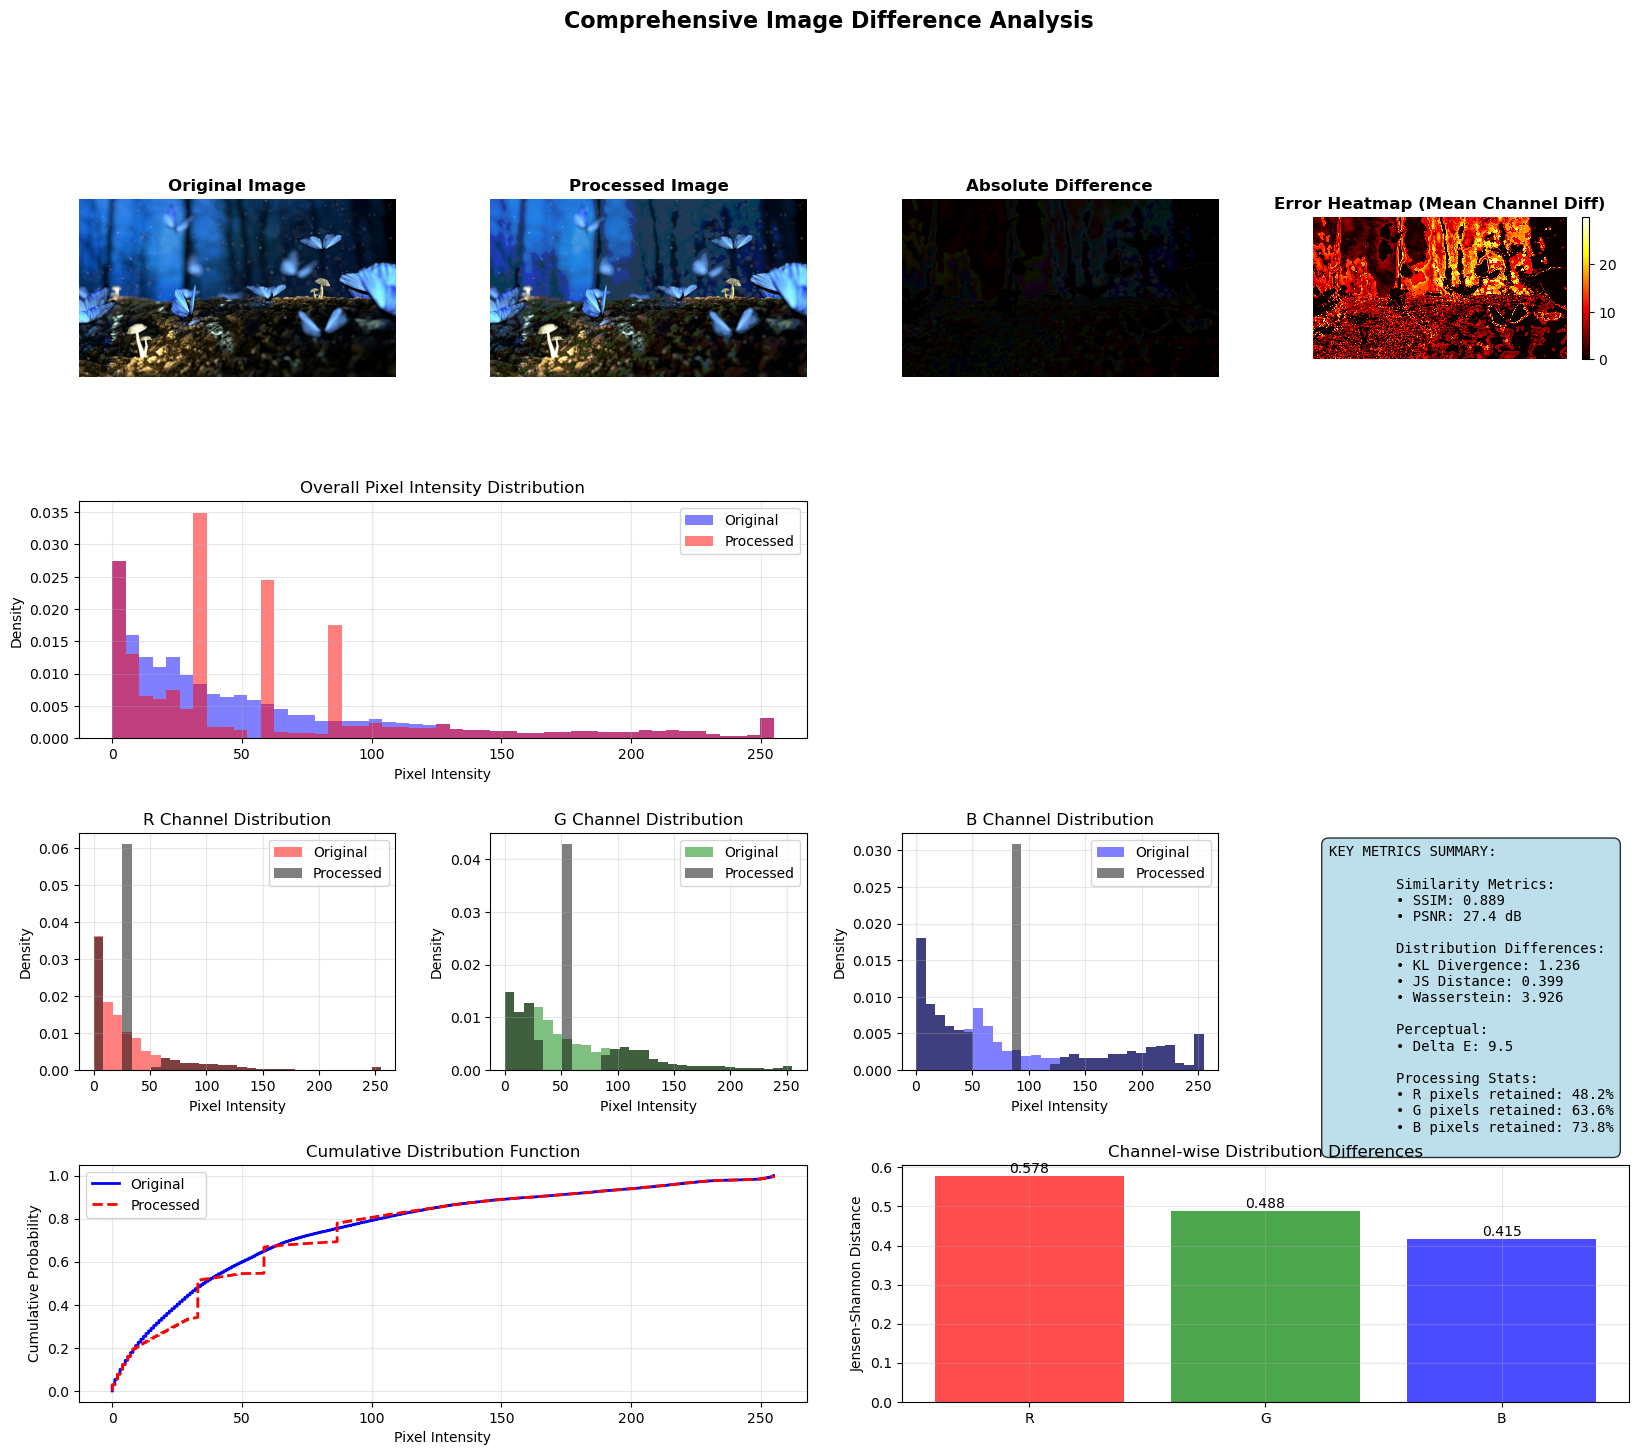

Processing image: (1536, 1025, 3)
Channel mean: 91.79, neff: 1165490
Channel mean: 94.75, neff: 1055936
Channel mean: 104.06, neff: 1154185
Mean Squared Error: 87.72
Peak Signal-to-Noise Ratio: 28.70 dB
Structural Similarity Index: 0.9360 (1.0 = identical)
Mean Absolute Error: 4.35
Histogram KL Divergence: 3.2220
Symmetric KL Divergence: 2.0239
Histogram JS Distance: 0.3866
Histogram Wasserstein Distance: 3.4201

R Channel:
  KL Divergence: 4.3952
  JS Distance: 0.4127
  Wasserstein: 4.7623

G Channel:
  KL Divergence: 5.7349
  JS Distance: 0.4620
  Wasserstein: 4.5976

B Channel:
  KL Divergence: 4.5678
  JS Distance: 0.4164
  Wasserstein: 3.6831
  Delta E: 8.41
  • Delta E < 1: Imperceptible difference
  • Delta E 1-3: Just noticeable difference
  • Delta E 3-6: Noticeable difference
  • Delta E > 6: Very noticeable difference


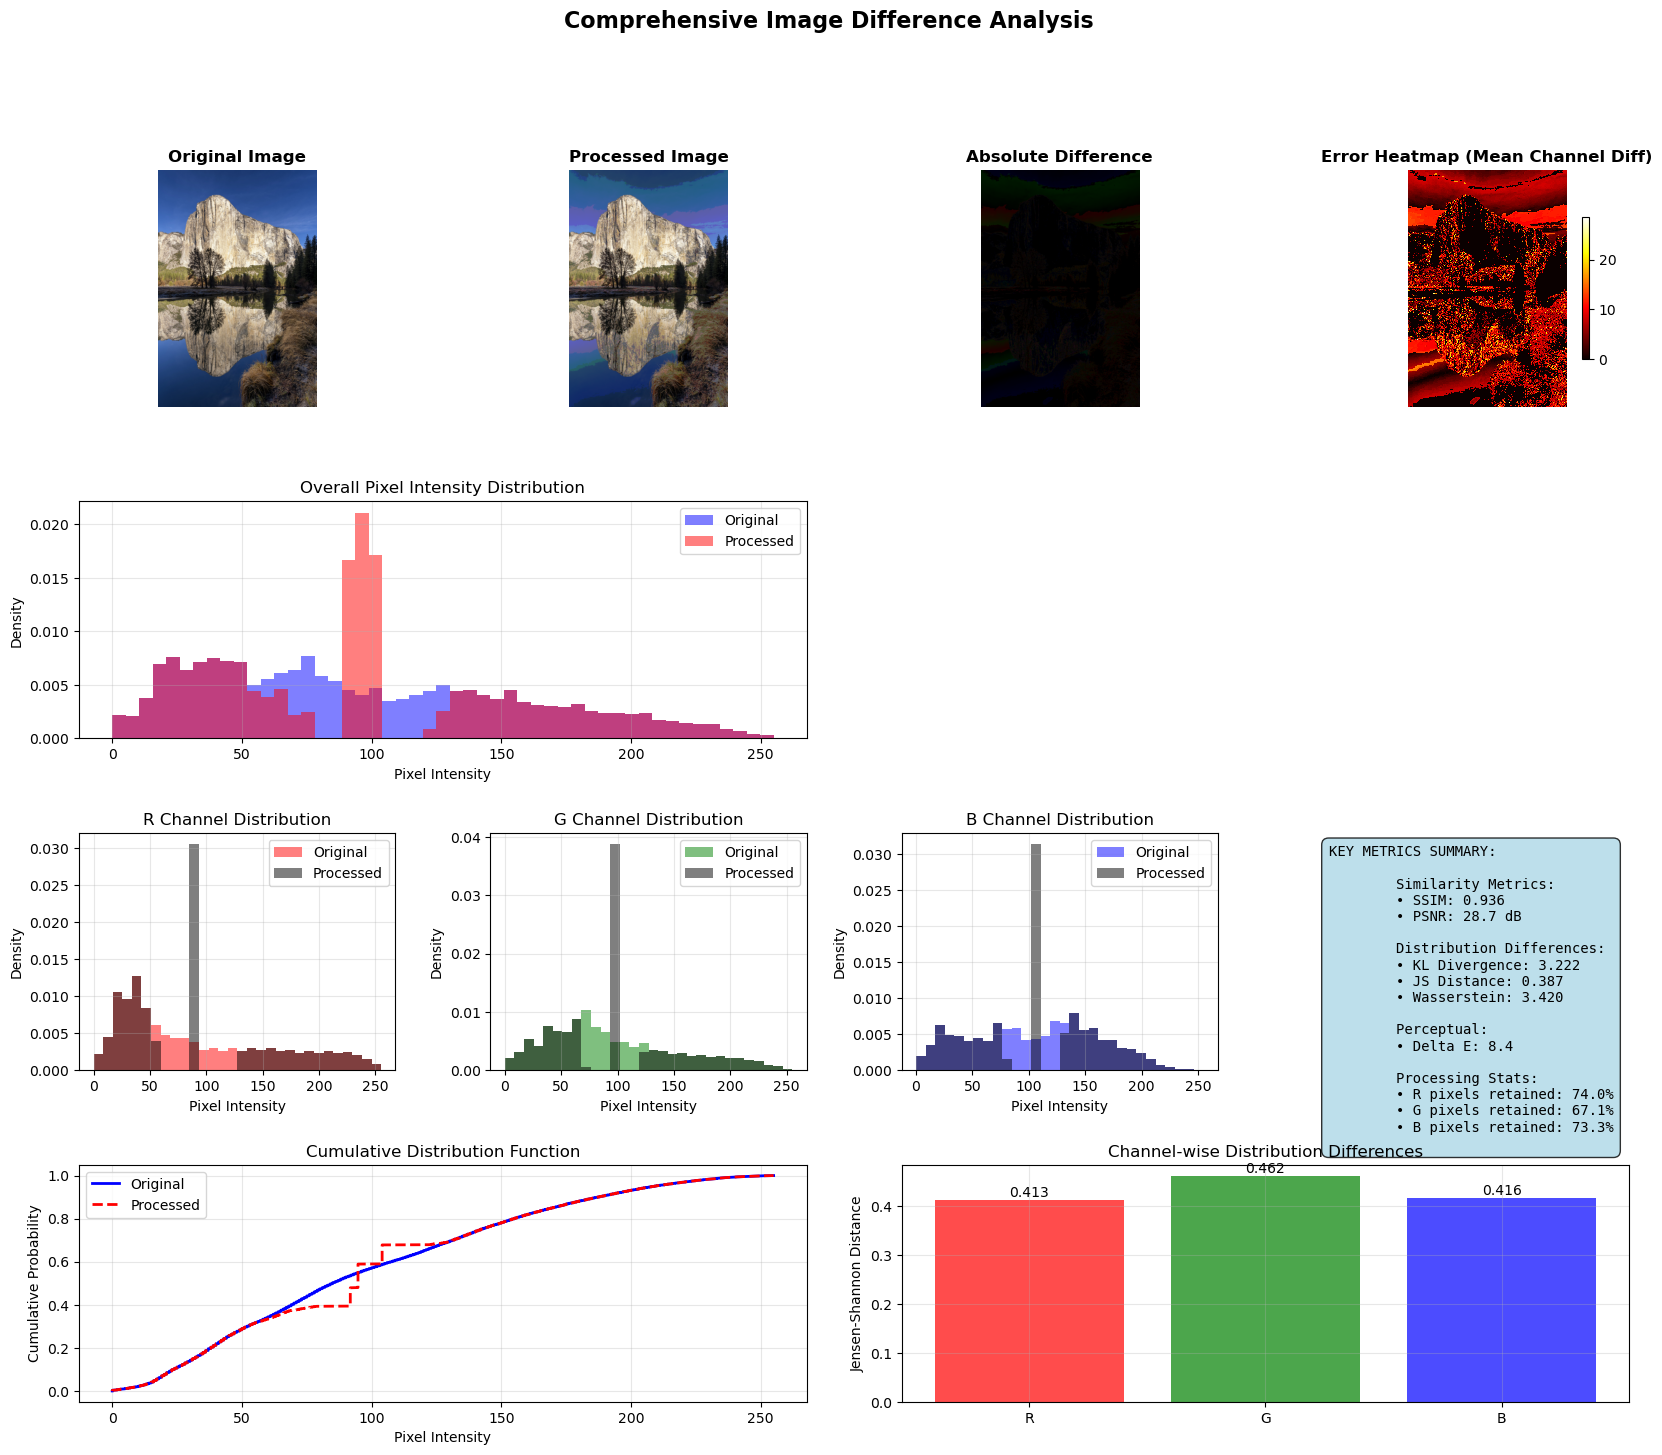

Processing image: (1330, 1980, 3)
Channel mean: 147.44, neff: 1977202
Channel mean: 71.68, neff: 2064290
Channel mean: 68.83, neff: 2187088
Mean Squared Error: 70.66
Peak Signal-to-Noise Ratio: 29.64 dB
Structural Similarity Index: 0.9249 (1.0 = identical)
Mean Absolute Error: 3.38
Histogram KL Divergence: 0.2588
Symmetric KL Divergence: 0.3839
Histogram JS Distance: 0.2739
Histogram Wasserstein Distance: 3.2714

R Channel:
  KL Divergence: 4.2759
  JS Distance: 0.4019
  Wasserstein: 3.5830

G Channel:
  KL Divergence: 3.6627
  JS Distance: 0.3742
  Wasserstein: 3.1088

B Channel:
  KL Divergence: 2.8070
  JS Distance: 0.3350
  Wasserstein: 3.4370
  Delta E: 5.09
  • Delta E < 1: Imperceptible difference
  • Delta E 1-3: Just noticeable difference
  • Delta E 3-6: Noticeable difference
  • Delta E > 6: Very noticeable difference


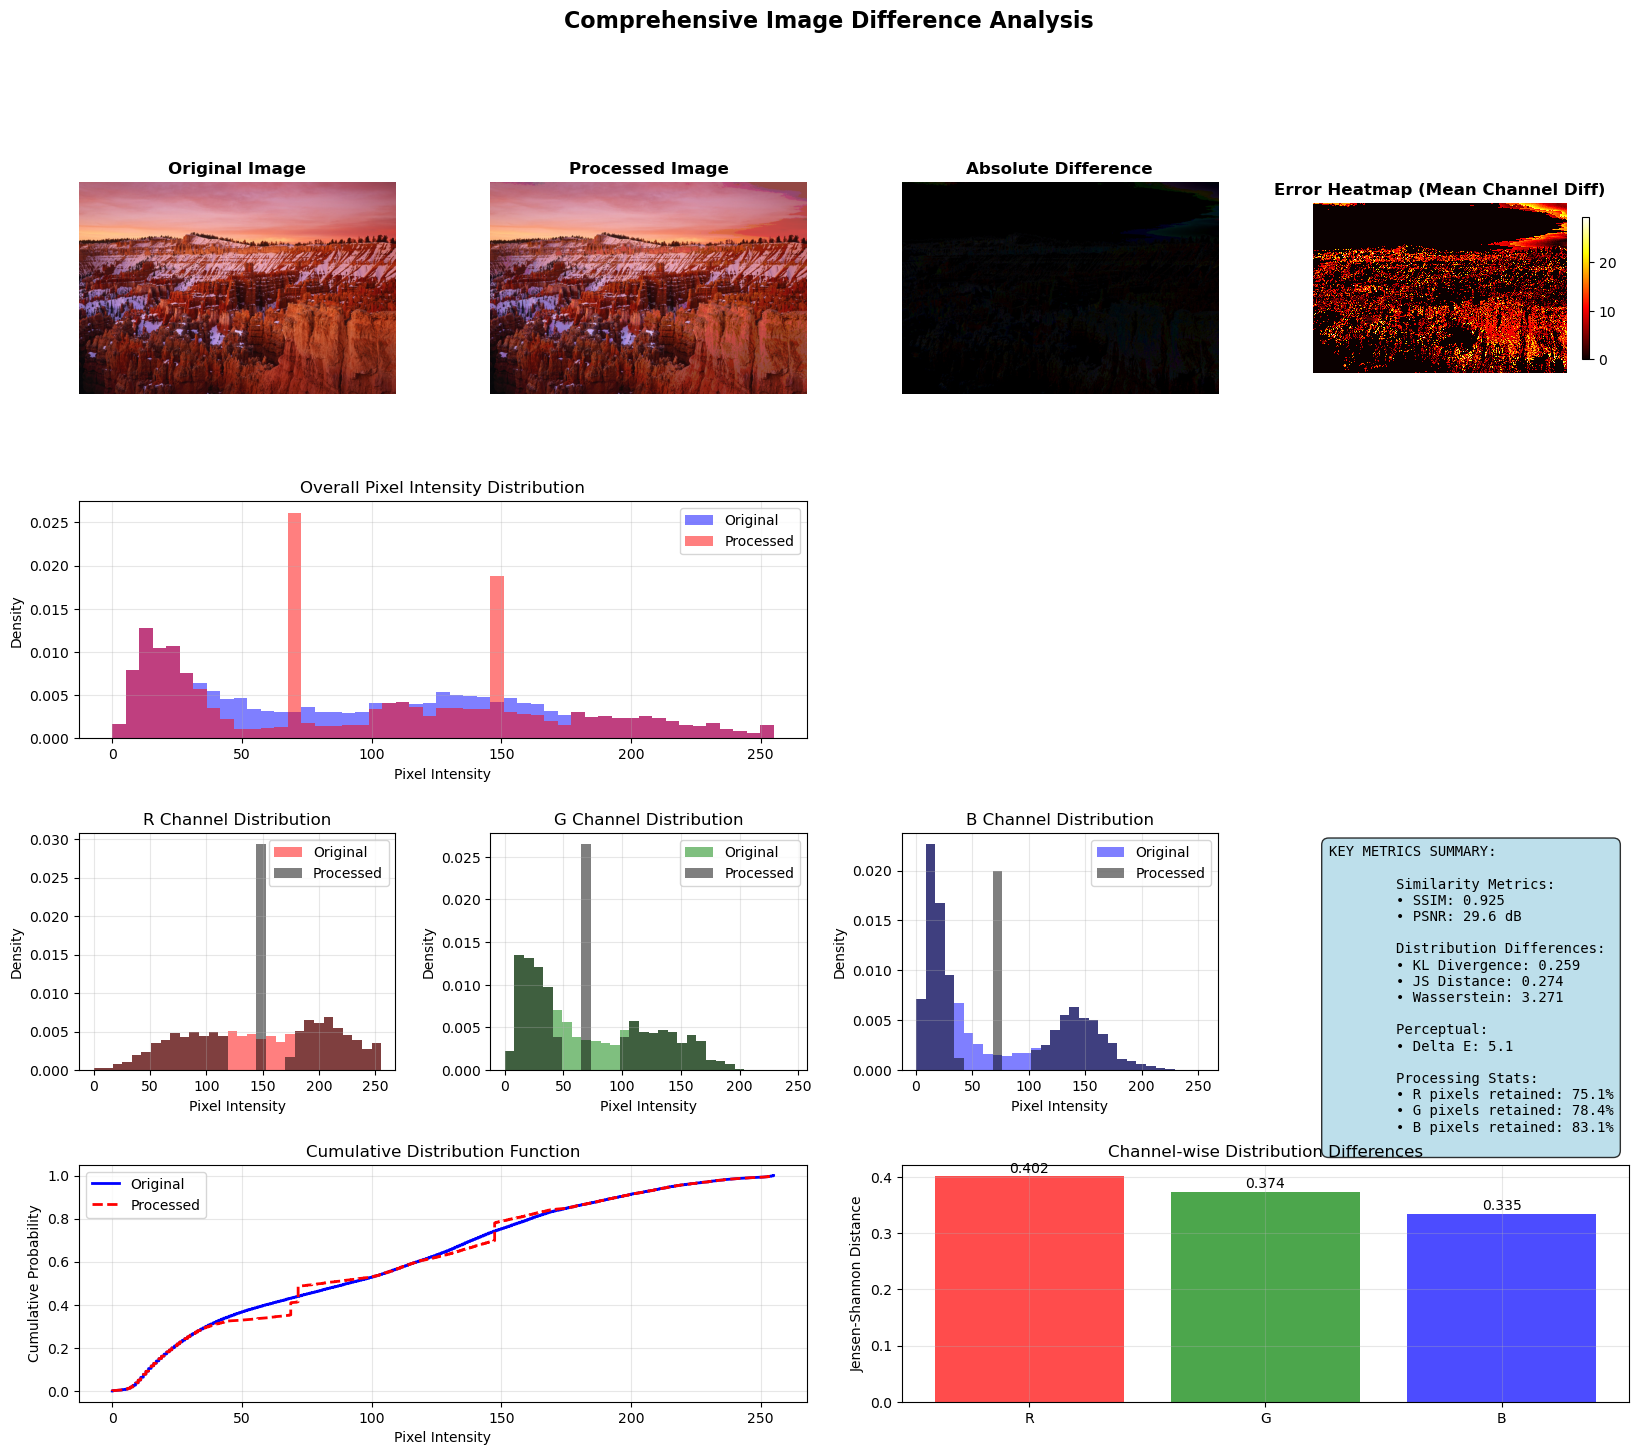

Processing image: (1322, 1980, 3)
Channel mean: 100.81, neff: 1849791
Channel mean: 104.58, neff: 1890845
Channel mean: 100.23, neff: 2075588
Mean Squared Error: 66.93
Peak Signal-to-Noise Ratio: 29.87 dB
Structural Similarity Index: 0.9230 (1.0 = identical)
Mean Absolute Error: 3.58
Histogram KL Divergence: 3.5934
Symmetric KL Divergence: 2.2147
Histogram JS Distance: 0.3836
Histogram Wasserstein Distance: 3.2225

R Channel:
  KL Divergence: 5.0550
  JS Distance: 0.4377
  Wasserstein: 4.7810

G Channel:
  KL Divergence: 4.8166
  JS Distance: 0.4215
  Wasserstein: 3.4283

B Channel:
  KL Divergence: 3.5382
  JS Distance: 0.3651
  Wasserstein: 2.5233
  Delta E: 5.66
  • Delta E < 1: Imperceptible difference
  • Delta E 1-3: Just noticeable difference
  • Delta E 3-6: Noticeable difference
  • Delta E > 6: Very noticeable difference


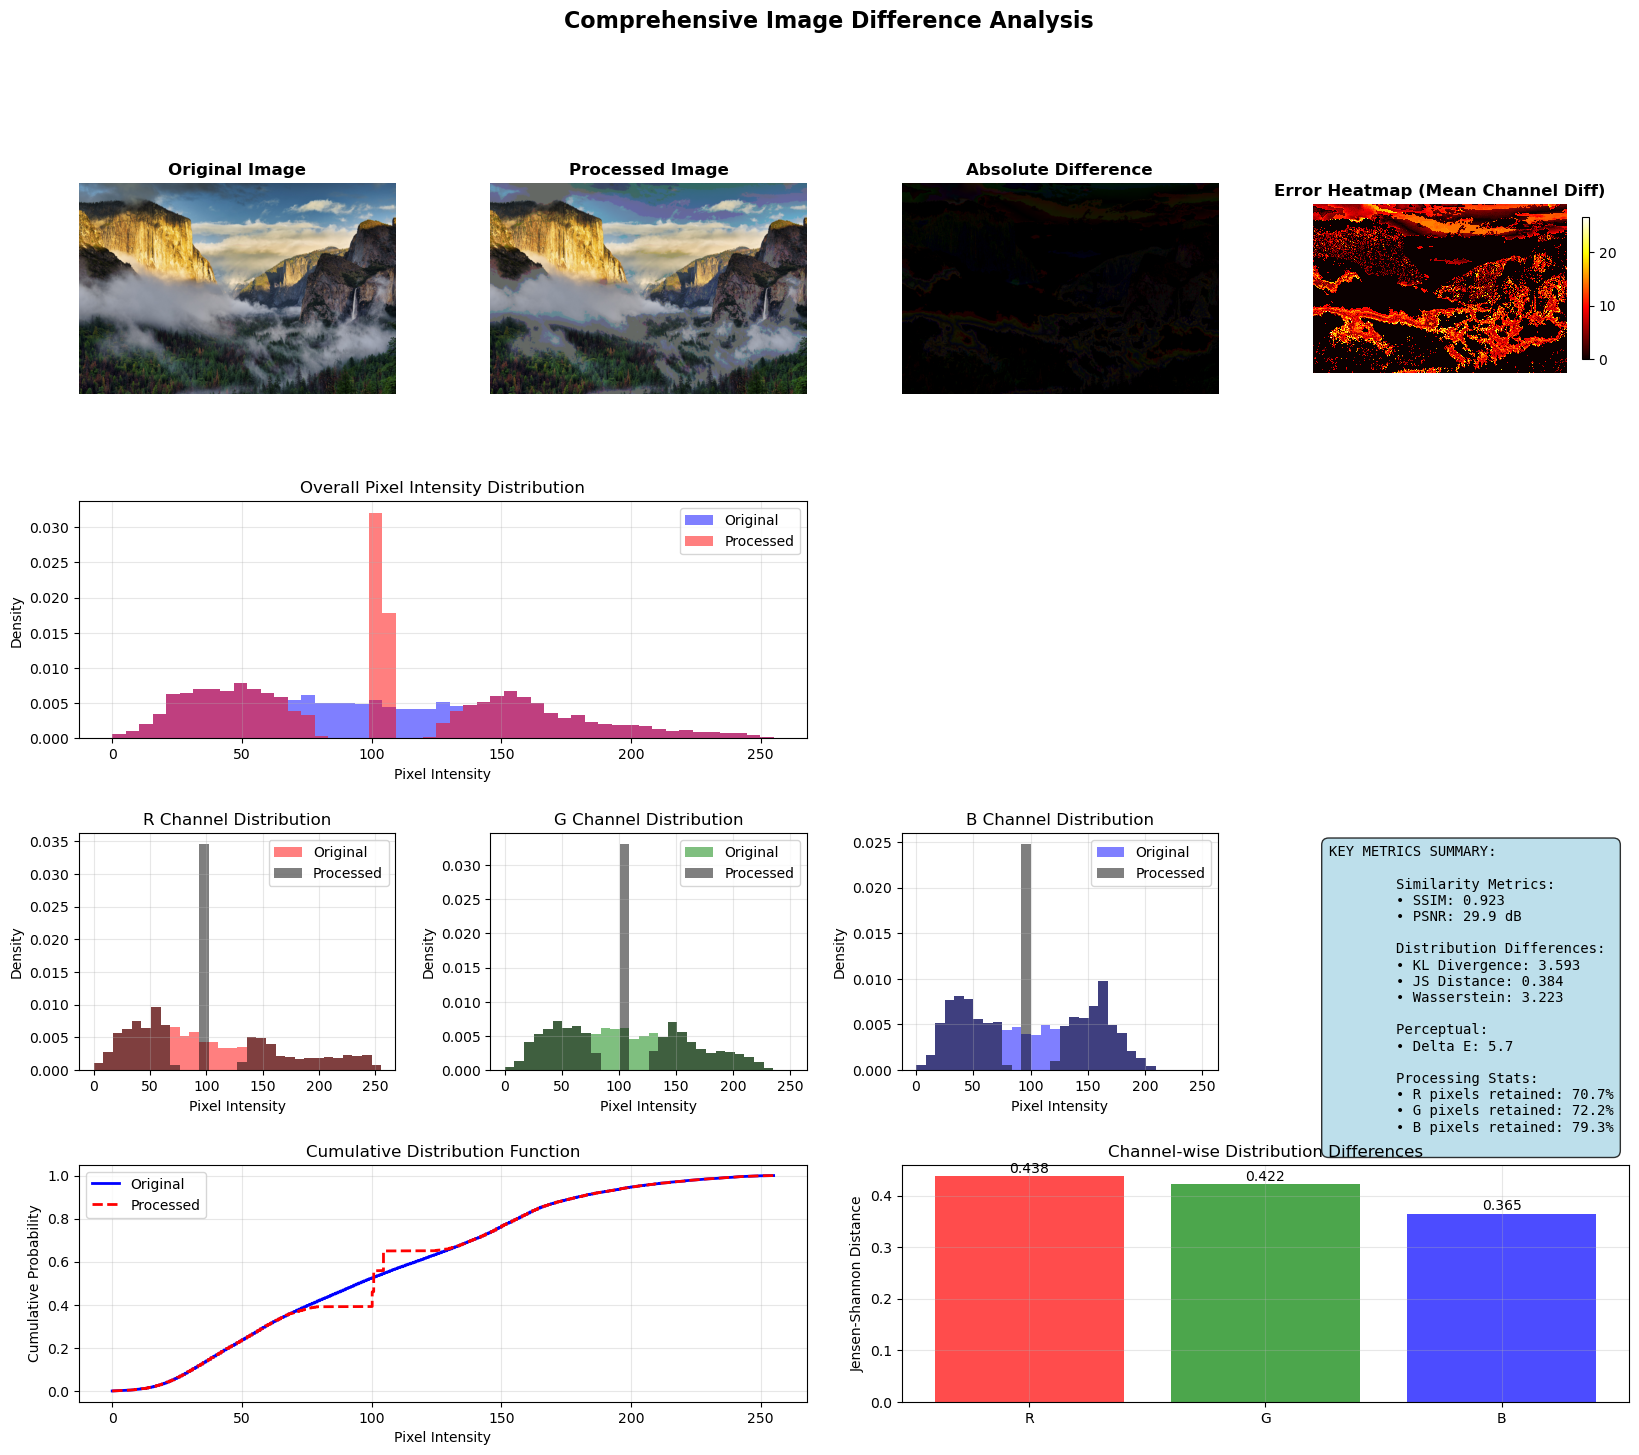

In [11]:
image_name = ['test1.jpg', 'Merced River_Yosemite.jpg', 'Bryce Canyon.jpg', 'yosemite valley.jpg']

process_image(image_name)

# wavelet DCT test

sparsity: 0.0030, neff: 25169, pixels retained: 0.30%


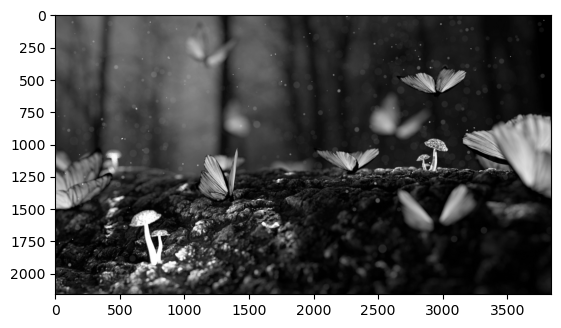

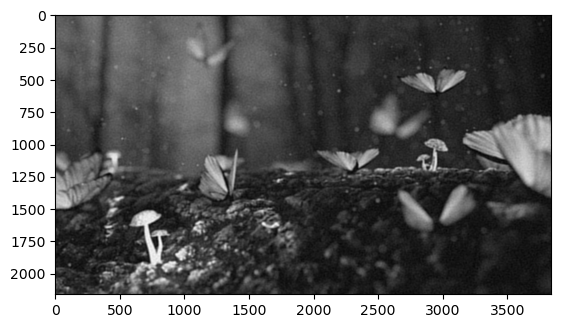

In [112]:
test_image = 'test1.jpg'
# wavelet DCT test

img = cv2.imread('figures/' + test_image)

dct = scipy.fftpack.dct(scipy.fftpack.dct(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float), axis=0, norm='ortho'), axis=1, norm='ortho')
original_shape = dct.shape
x = dct.copy()
x = x.reshape(-1)
x = np.array(x)
norm_x = np.abs(x) / np.sum(np.abs(x))
neff = floor(1 / np.sum(norm_x ** 2))
sort_x_indices = np.argsort(norm_x)[::-1]
top_neff_indices = sort_x_indices[:neff] if neff > 0 else []
weight_filter = np.zeros_like(norm_x)
if len(top_neff_indices) > 0:
    weight_filter[top_neff_indices] = x[top_neff_indices]

# back to image
weight_filter = weight_filter.reshape(original_shape)

#sparsity
sparsity = np.sum(weight_filter != 0) / weight_filter.size

print(f'sparsity: {sparsity:.4f}, neff: {neff}, pixels retained: {(len(top_neff_indices)/x.size)*100:.2f}%')

# from dct back to image

idct = scipy.fftpack.idct(scipy.fftpack.idct(dct, axis=0, norm='ortho'), axis=1, norm='ortho')

plt.imshow(idct, cmap='gray')
plt.show()

filtered_idct = scipy.fftpack.idct(scipy.fftpack.idct(weight_filter, axis=0, norm='ortho'), axis=1, norm='ortho')

plt.imshow(filtered_idct, cmap='gray')
plt.show()


In [113]:
# Energy fraction retained in DCT domain
energy_total = np.sum(dct**2)
energy_kept  = np.sum(weight_filter**2)
print(f'Energy kept: {energy_kept/energy_total:.4f}')

# PSNR / SSIM on reconstructions (uint8 range 0..255)
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
orig = scipy.fftpack.idct(scipy.fftpack.idct(dct, axis=0, norm='ortho'), axis=1, norm='ortho')
recon = scipy.fftpack.idct(scipy.fftpack.idct(weight_filter, axis=0, norm='ortho'), axis=1, norm='ortho')
orig8  = np.clip(orig,0,255).astype(np.uint8)
recon8 = np.clip(recon,0,255).astype(np.uint8)
print('PSNR:', psnr(orig8,recon8,data_range=255))
print('SSIM:', ssim(orig8,recon8,data_range=255))


Energy kept: 0.9885
PSNR: 30.337657881618757
SSIM: 0.8593514380431404


In [115]:
i ,j = 10, 200

In [125]:
block = img[i:i+800, j:j+800]
Z = scipy.fftpack.dct(scipy.fftpack.dct(cv2.cvtColor(block, cv2.COLOR_BGR2GRAY).astype(float), axis=0, norm='ortho'), axis=1, norm='ortho')              # 2-D DCT
q = np.abs(Z)/np.sum(np.abs(Z))
nu = int(np.floor(1/np.sum(q*q)))
idx = np.argsort(np.abs(Z).ravel())[::-1][:nu]
Zk = np.zeros_like(Z).ravel(); Zk[idx] = Z.ravel()[idx]
recon_block = scipy.fftpack.idct(scipy.fftpack.idct(Zk.reshape(800,800), axis=0, norm='ortho'), axis=1, norm='ortho')


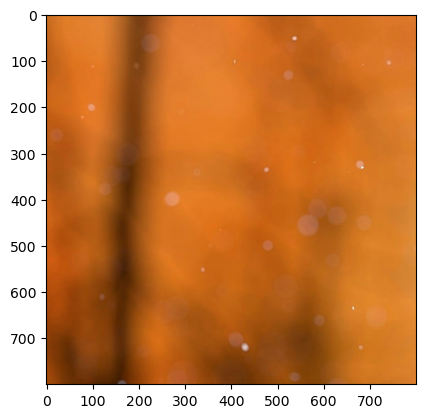

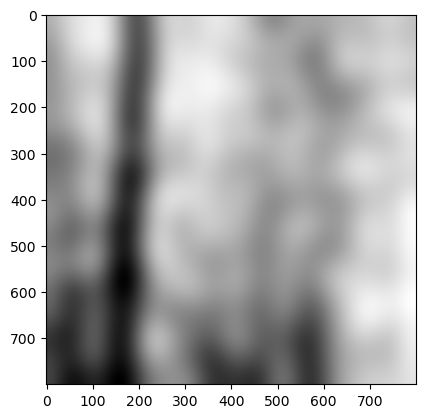

In [126]:
plt.imshow(block, cmap='gray')
plt.show()

plt.imshow(recon_block, cmap='gray')
plt.show()

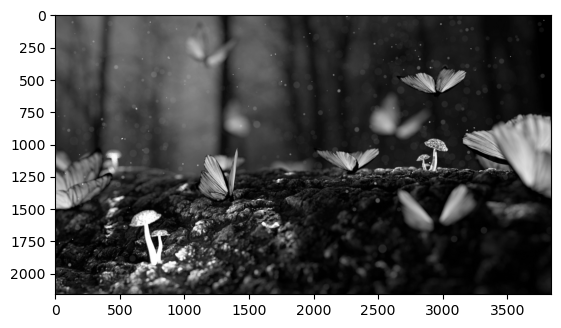

In [108]:
# from dct back to image

idct = scipy.fftpack.idct(scipy.fftpack.idct(dct, axis=0, norm='ortho'), axis=1, norm='ortho')

plt.imshow(idct, cmap='gray')
plt.show()

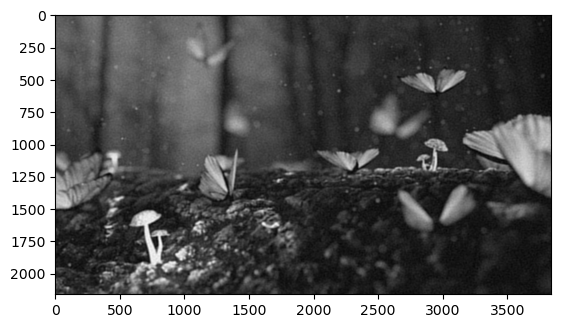

In [109]:
filtered_idct = scipy.fftpack.idct(scipy.fftpack.idct(weight_filter, axis=0, norm='ortho'), axis=1, norm='ortho')

plt.imshow(filtered_idct, cmap='gray')
plt.show()